time elapsed = 0.32, device = cpu


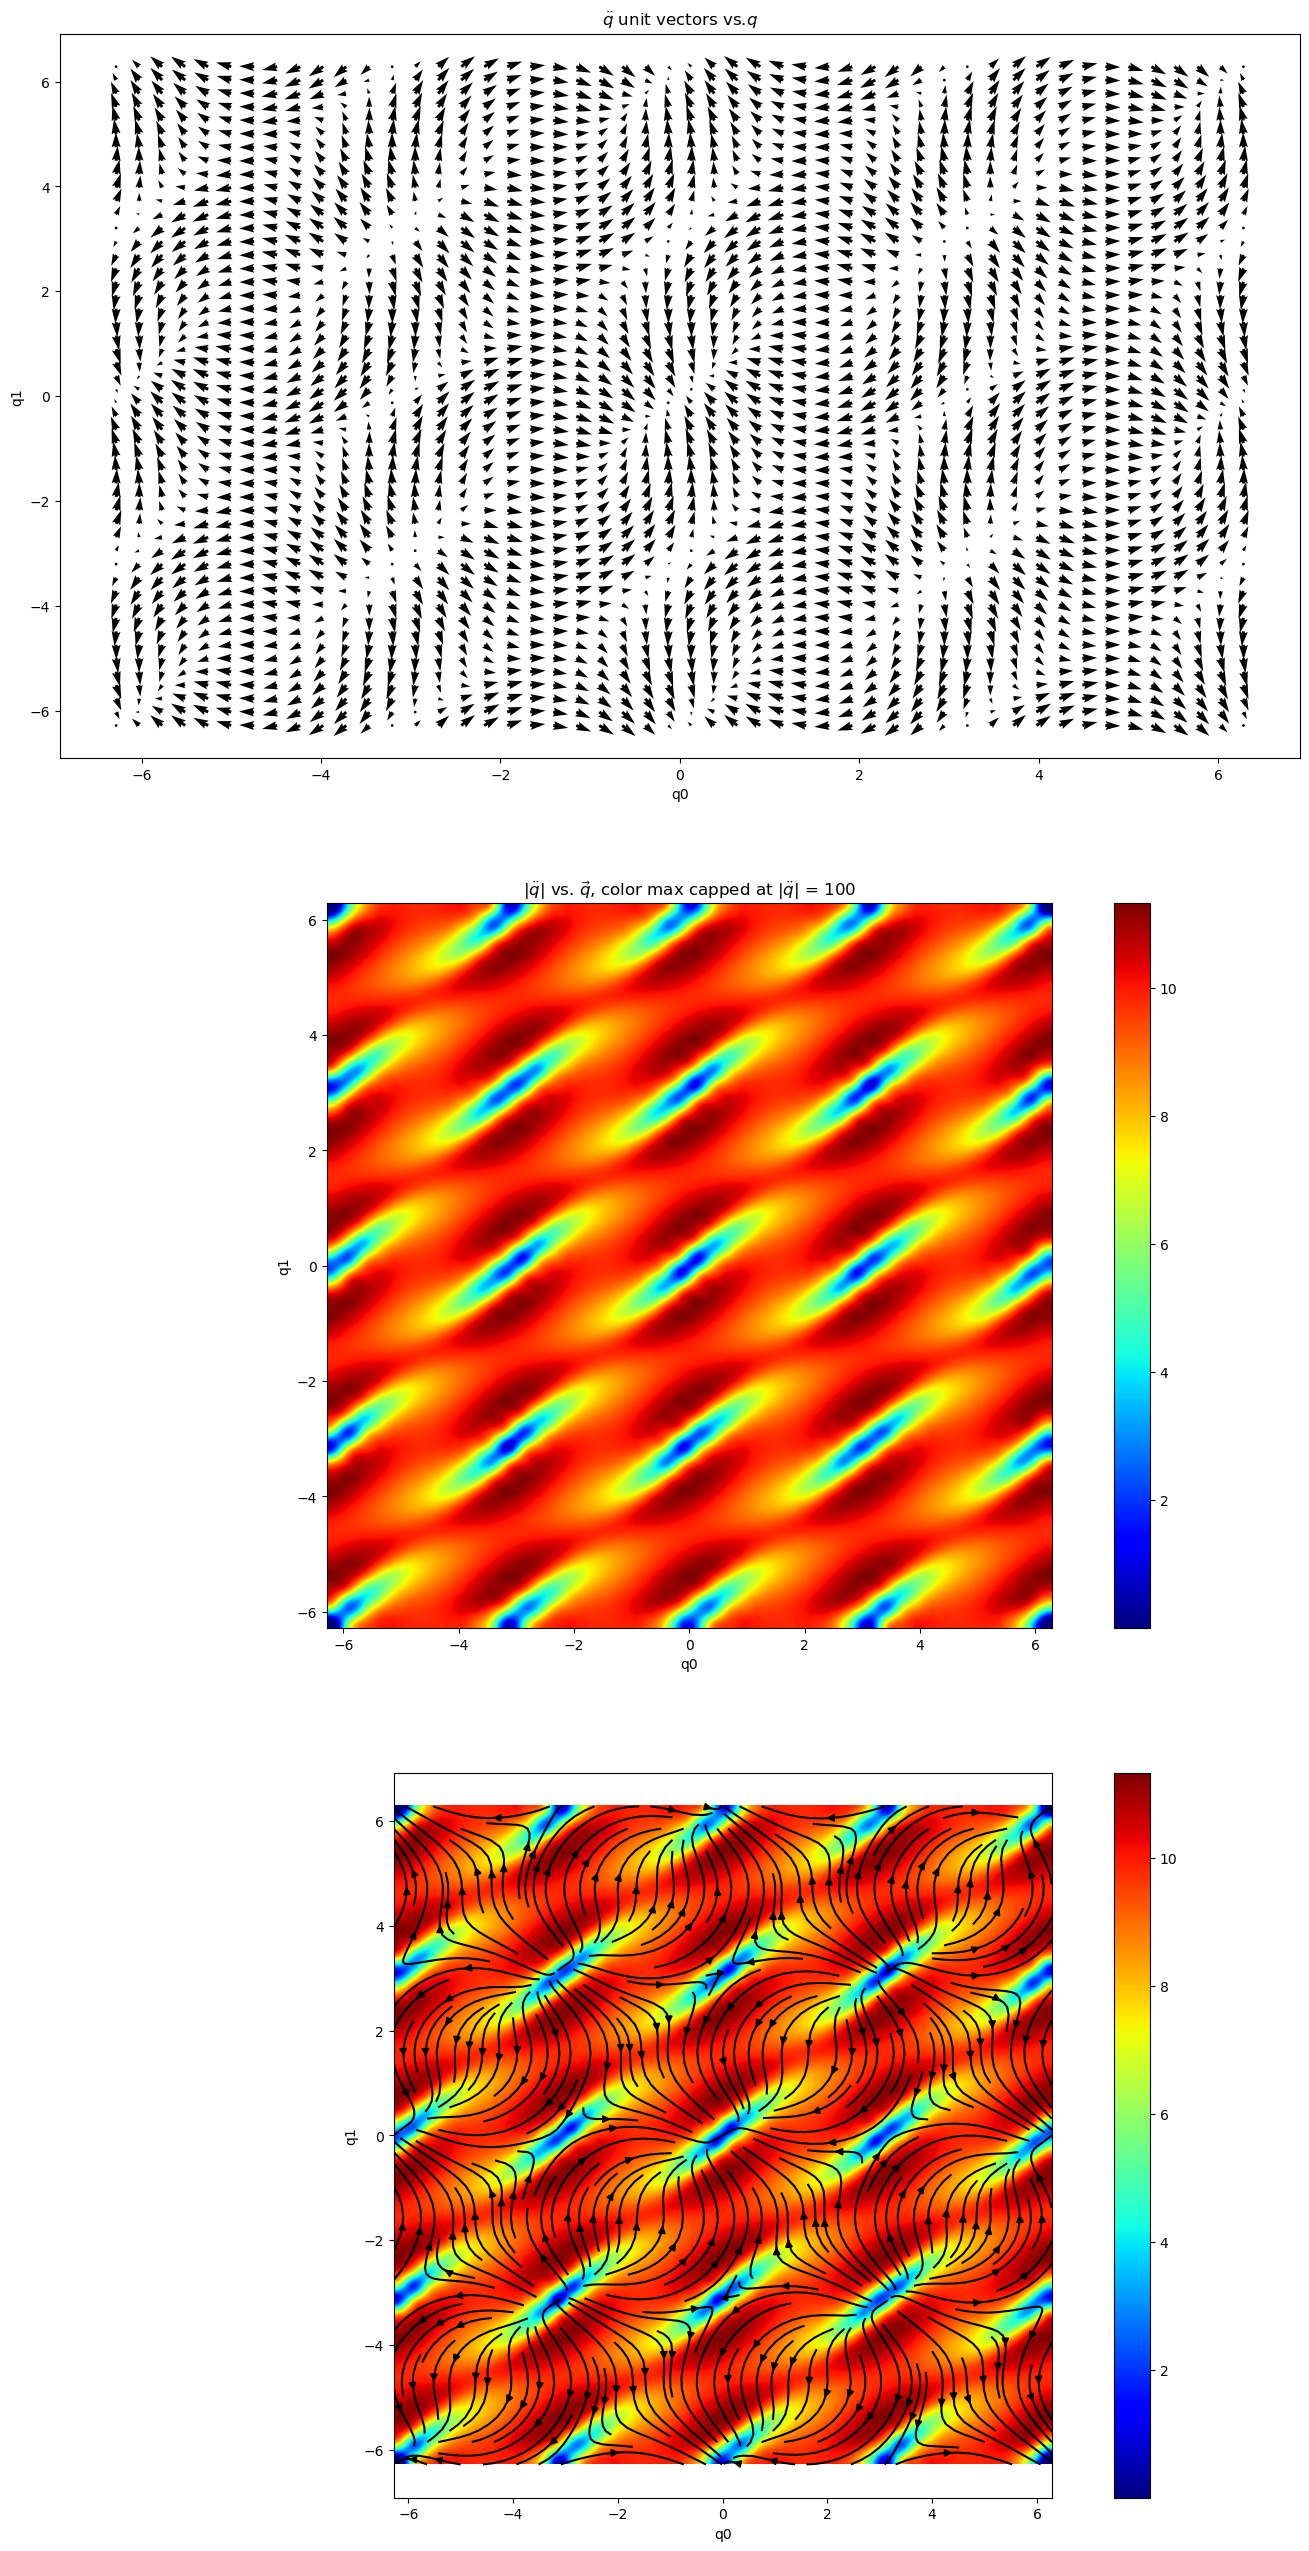

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
#import torch
from torch import tensor, sum, log, max, cos, sin, pi, clone, sqrt, mean, std, sort
from scipy.constants import g



from dpfuncs import *

dev = 'cpu' #10x slower running on MPS :(
torch.set_default_device(dev)

t1 = time.time()
#####
# problem setup

m1 = torch.tensor([1],dtype=torch.float)
l1 = torch.tensor([1],dtype=torch.float)
m2 = torch.tensor([1],dtype=torch.float)
l2 = torch.tensor([1],dtype=torch.float)

n_points = 50**2

grid_sampling = 1

t0_min = -2*pi
t0_max = 2*pi
t1_min = -2*pi
t1_max = 2*pi

tdot_min = -0
tdot_max = 0


if grid_sampling == 1:
    Qv, QDv = grid_sampling_q_no_qdot(t0_min,t0_max,t1_min,t1_max,n_points)
else:
    Qv, QDv = rand_sampling_q_no_qdot(t0_min,t0_max,t1_min,t1_max,n_points)
n_points = Qv.shape[1]






out = QDDv(Qv,QDv,m1,m2,l1,l2).mT.cpu().detach()
out_true = QDD_true_v(Qv,QDv,m1,m2,l1,l2).cpu().detach()

Qv = Qv.cpu().detach()
QDv = QDv.cpu().detach()


outmag = torch.ones(n_points).cpu().detach()#(out[:,0]**2 + out[:,1]**2)**.5
#print(out)

t_elapsed = time.time() - t1
print(f"time elapsed = {t_elapsed:.2f}, device = {dev}")


#####
# plotting

quiver_points = 75**2 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points

n_side = min(tensor([int(sqrt(tensor(n_points))), int(sqrt(tensor(quiver_points)))]) )

t0v = Qv[0,:quiver_points].reshape(n_side,n_side).mT.numpy()
t1v = Qv[1,:quiver_points].reshape(n_side,n_side).mT.numpy()

u = out[0,:quiver_points].reshape(n_side,n_side).numpy()
v = out[1,:quiver_points].reshape(n_side,n_side).numpy()

if grid_sampling == 1:
    fig,axs = plt.subplots(3,1,figsize=(16,32))
    
    #scatter = axs[0].scatter(Qv[0,:],Qv[1,:],c=sqrt(sum(out**2,axis=0)),cmap='jet')
    #plt.colorbar(scatter,ax=axs[0])
    axs[0].quiver(Qv[0,:quiver_points],Qv[1,:quiver_points],out[0,:quiver_points]/outmag[:quiver_points],out[1,:quiver_points]/outmag[:quiver_points])
    axs[0].set_xlabel('q0')
    axs[0].set_ylabel('q1')
    axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

    interp_method = 'lanczos'
    cmax = 100
    colors = axs[1].imshow(np.sqrt(out[0,:]**2 + out[1,:]**2).reshape(int(sqrt(tensor(n_points))),int(sqrt(tensor(n_points)))),extent=[t0v.min(),t0v.max(),t1v.min(),t1v.max()],origin='lower',cmap='jet',interpolation=interp_method)
    plt.colorbar(colors,ax=axs[1])
    axs[1].set_xlabel('q0')
    axs[1].set_ylabel('q1')
    axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')
    
    
    
    colors = axs[2].imshow(np.sqrt(out[0,:]**2 + out[1,:]**2).reshape(int(sqrt(tensor(n_points))),int(sqrt(tensor(n_points)))),extent=[t0v.min(),t0v.max(),t1v.min(),t1v.max()],cmap='jet',interpolation=interp_method,origin='lower')
    plt.colorbar(colors,ax=axs[2])
    axs[2].streamplot(t0v,t1v,v,u,color='black',density=2)
    axs[2].set_xlabel('q0')
    axs[2].set_ylabel('q1')
    
    plt.show()

else:
    fig,axs = plt.subplots(2,1,figsize=(8,16))
    
    #scatter = axs[0].scatter(Qv[0,:],Qv[1,:],c=sqrt(sum(out**2,axis=0)),cmap='jet')
    #plt.colorbar(scatter,ax=axs[0])
    axs[0].quiver(Qv[0,:quiver_points],Qv[1,:quiver_points],out[0,:quiver_points]/outmag[:quiver_points],out[1,:quiver_points]/outmag[:quiver_points])
    axs[0].set_xlabel('q0')
    axs[0].set_ylabel('q1')
    axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')
    
    cmax = 100
    scatter = axs[1].scatter(Qv[0,:],Qv[1,:],c=sqrt(sum(out**2,axis=0)),cmap='jet')
    plt.colorbar(scatter,ax=axs[1])
    axs[1].set_xlabel('q0')
    axs[1].set_ylabel('q1')
    axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')

